In [1]:
import numpy as np
import pandas as pd
import pyrssa as prs
import matplotlib.pyplot as plt
from typing import Literal

# Примитивный пример с синусом

## Случай без шума

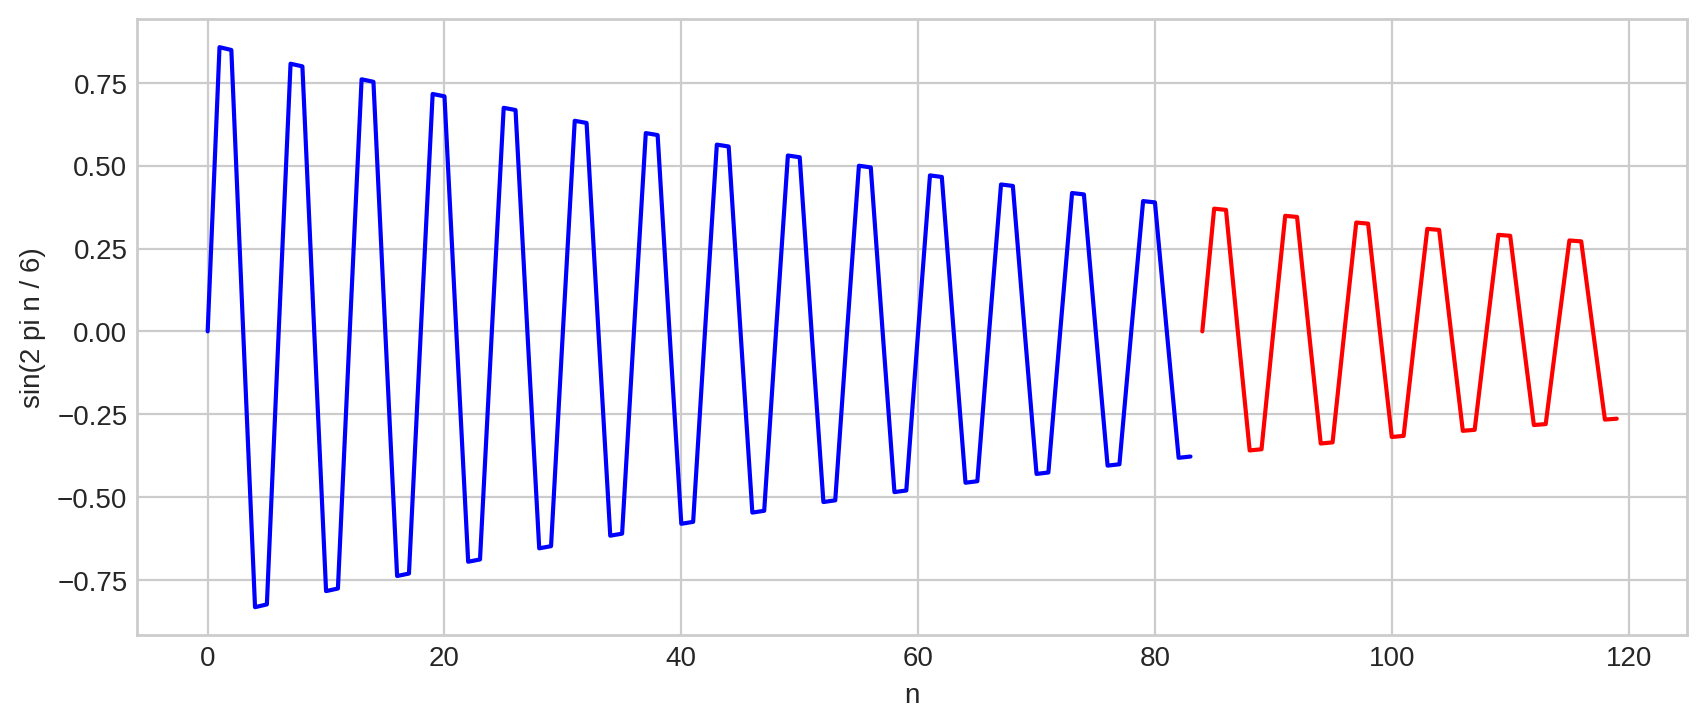

In [2]:
%matplotlib inline

N = 120
X_sin = np.array(range(0, N))
y_sin = np.exp(-1e-2 * X_sin) * np.sin(X_sin * 2 * np.pi / 6)

def train_test_split_ts(X, y, test_rate):
    N = len(X)
    assert N == len(y)
    last_train = int((1 - test_rate) * N)
    X_train, X_test = X[:last_train], X[last_train:]
    y_train, y_test = y[:last_train], y[last_train:]
    return X_train, X_test, y_train, y_test

tr = 0.3
X_sin_train, X_sin_test, y_sin_train, y_sin_test = train_test_split_ts(X_sin, y_sin, tr)

fig = plt.figure(figsize=(10, 4), dpi=200)
plt.xlabel("n")
plt.ylabel("sin(2 pi n / 6)")
plt.plot(X_sin_train, y_sin_train, color="blue")
plt.plot(X_sin_test, y_sin_test, color="red")
plt.show()

### RNN

На ряде без шума SSA проверять не имеет смысла (при $r=2$ ошибка будет нулевой)

In [3]:
# TODO: применить RNN к предсказанию синуса выше в отсутствие шума

## Случай с шумом

In [4]:
def gen_noised_ts(y, noise_func=np.random.Generator.normal, **kwargs):
    N = len(y)
    noise = noise_func(size=N, **kwargs)

    return y + noise


def rmse(true, pred) -> float:
    return np.sqrt(np.mean((true - pred) ** 2))


sd = 0.6
repeats = 100
seed = 42

### SSA

In [5]:
def pred_ssa(y, L, rank, length, method: Literal["r", "v"]="r"):
    y_ssa = prs.ssa(y, L, kind="1d-ssa")
    match method:
        case "r":
            return prs.rforecast(y_ssa, groups={"Signal": range(1, rank + 1)}, length=length)
        case "v":
            return prs.vforecast(y_ssa, groups={"Signal": range(1, rank + 1)}, length=length)
    


def test_ssa(y_train, y_test, repeats, L, rank, seed=None, method: Literal["r", "v"]="r"):
    pred_len = len(y_test)
    rng = np.random.default_rng(seed)
    return np.mean(
        [
            rmse(
                y_test,
                pred_ssa(
                    gen_noised_ts(y_train, noise_func=rng.normal, scale=sd),
                    L,
                    rank,
                    pred_len,
                    method=method
                ),
            )
            for _ in range(repeats)
        ]
    )

ssa_rmse_r = test_ssa(
    y_train=y_sin_train, y_test=y_sin_test, repeats=repeats, L=N / 2, rank=2, seed=seed, method="r"
)

ssa_rmse_v = test_ssa(
    y_train=y_sin_train, y_test=y_sin_test, repeats=repeats, L=N / 2, rank=2, seed=seed, method="v"
)

print(f"RMSE for SSA (recursive forecast): {ssa_rmse_r:.5f}")
print(f"RMSE for SSA (vector forecast): {ssa_rmse_v:.5f}")

RMSE for SSA (recursive forecast): 0.17500
RMSE for SSA (vector forecast): 0.16676


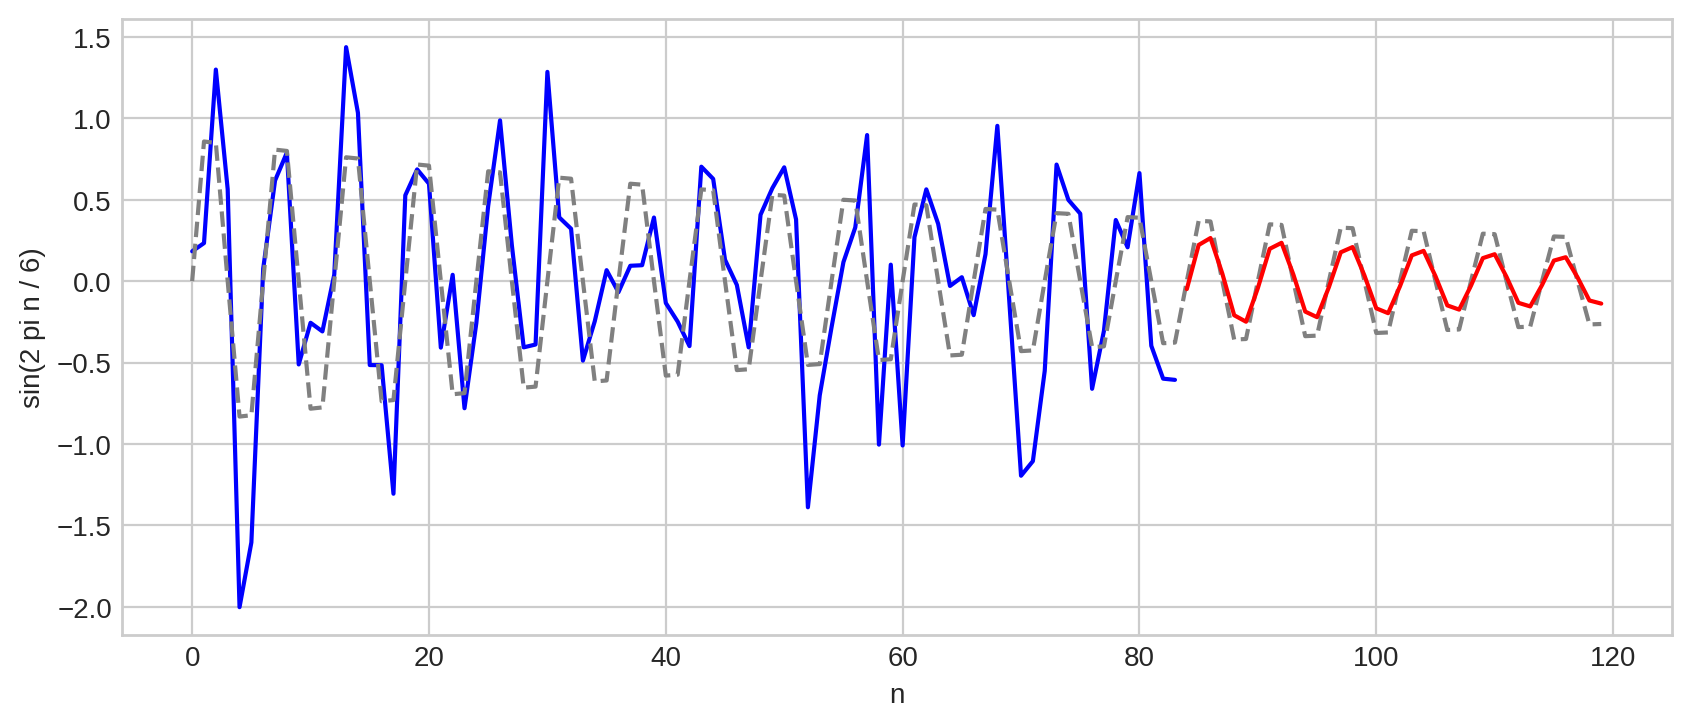

In [6]:
y_sin_train_noised = gen_noised_ts(
        y_sin_train, noise_func=np.random.default_rng(seed=seed).normal, scale=sd
    )
y_sin_pred = pred_ssa(
    y_sin_train_noised,
    N / 2,
    2,
    len(y_sin_test),
    "v"
)

fig = plt.figure(figsize=(10, 4), dpi=200)
plt.xlabel("n")
plt.ylabel("sin(2 pi n / 6)")
plt.plot(X_sin_train, y_sin_train_noised, color="blue")
plt.plot(X_sin, y_sin, color="gray", linestyle="--")
plt.plot(X_sin_test, y_sin_pred, color="red")
plt.show()

### RNN

In [7]:
# TODO: добавить предсказание для RNN по аналогии с тем что выше

# Реальный временной ряд

## Количество релизов музыкальных композиций по месяцам

In [8]:
df_music = pd.read_csv("./data/tracks_by_date.csv")
df_music.head()

,Unnamed: 0,Date,Count
0,1,1950-01,4
1,2,1950-02,16
2,3,1950-03,4
3,4,1950-04,17
4,5,1950-05,26


In [9]:
music_ts_index = pd.date_range(start=df_music["Date"][1], freq='ME', periods=len(df_music)).strftime('%Y-%m')
music_ts = pd.Series(df_music.Count.values, index=music_ts_index)
music_ts_recent = music_ts["2014-01":"2018-01"]
music_ts_actual = music_ts["2018-01":"2020-01"]
music_ts_actual_mspe = music_ts["2018-02":"2020-01"]

### Графики данных 

- `music_ts`: за всё время
- `music_ts_recent`: за 2014-2018 гг. - для обучения
- `music_ts_actual`: за 2018-2020 - для тестирования

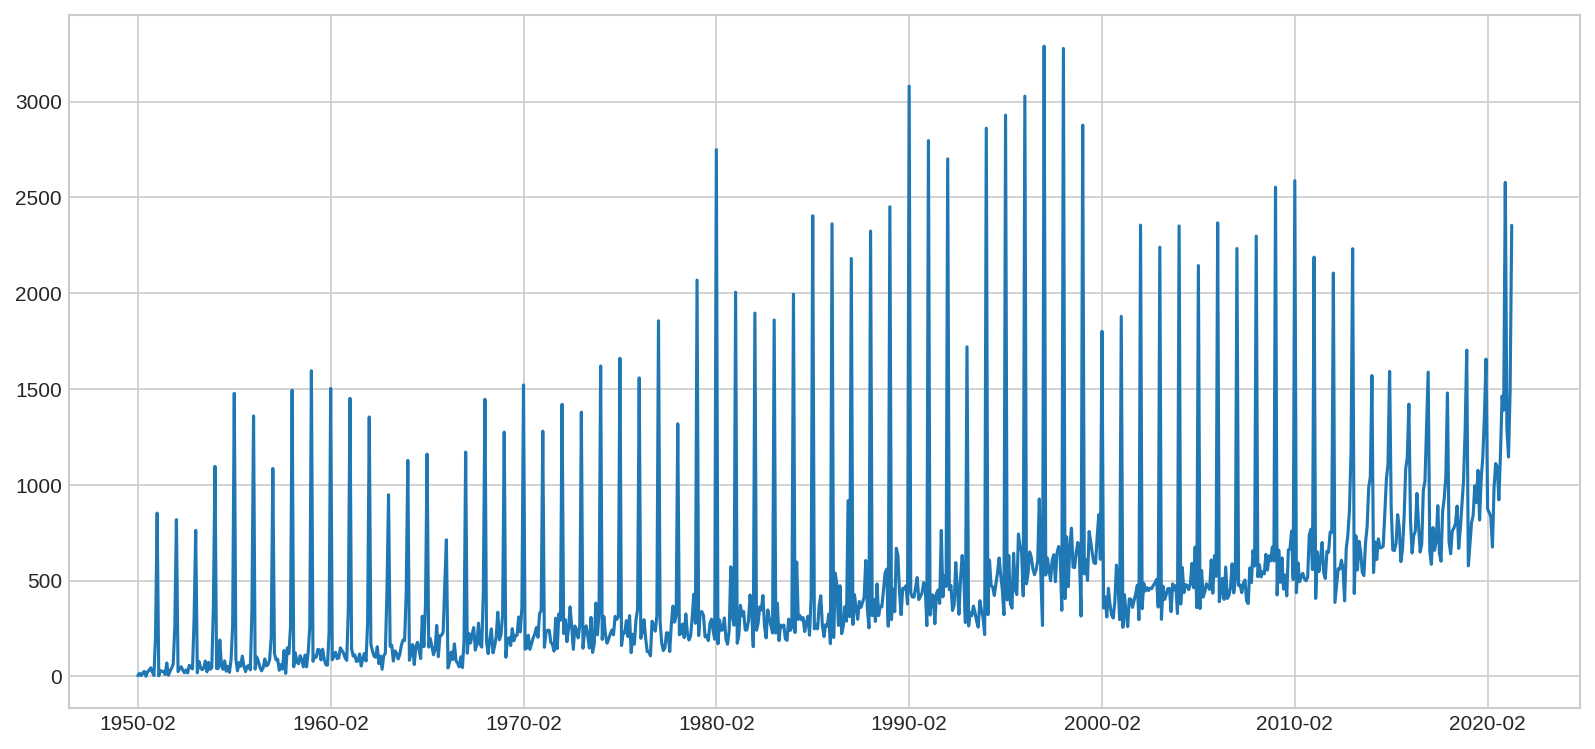

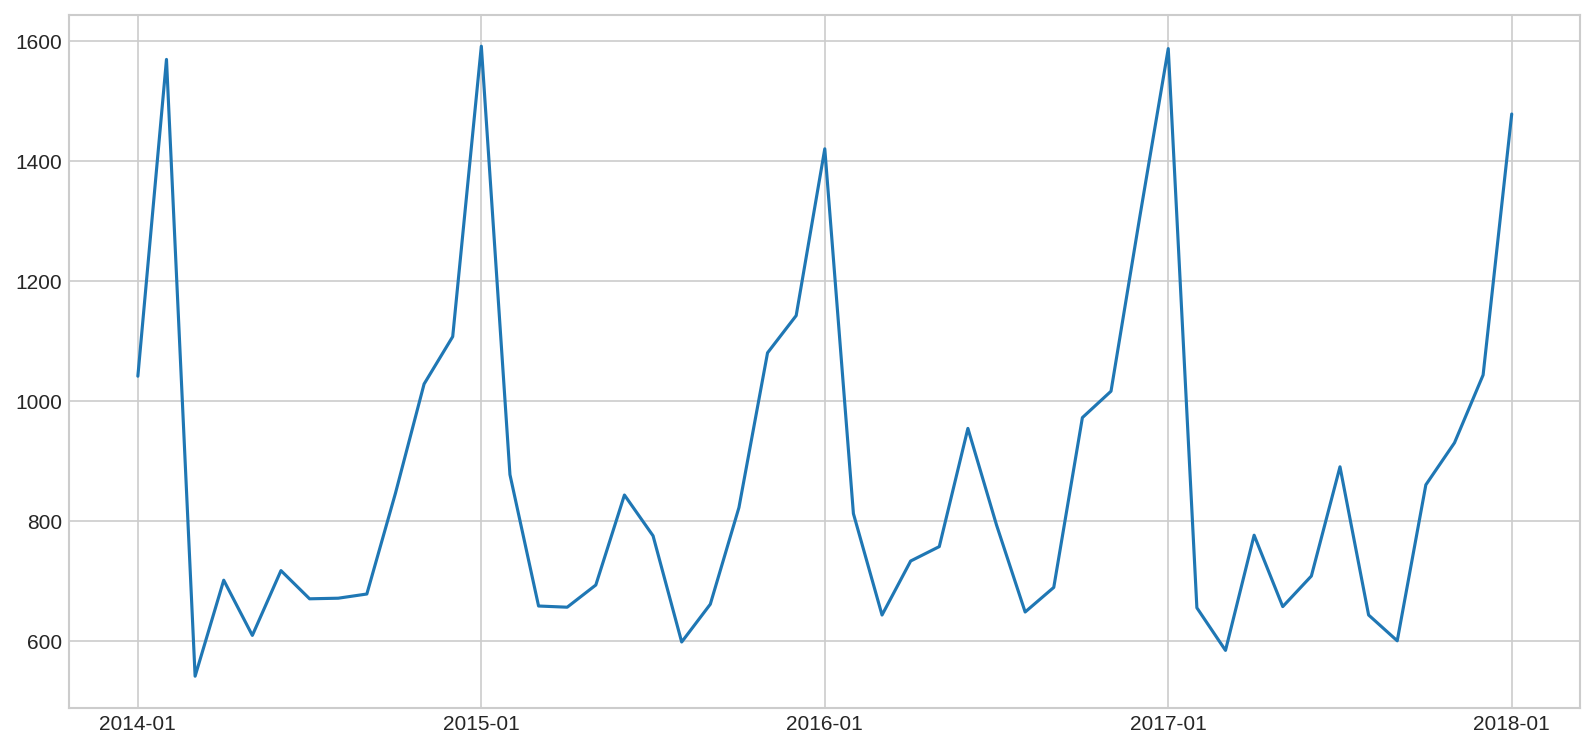

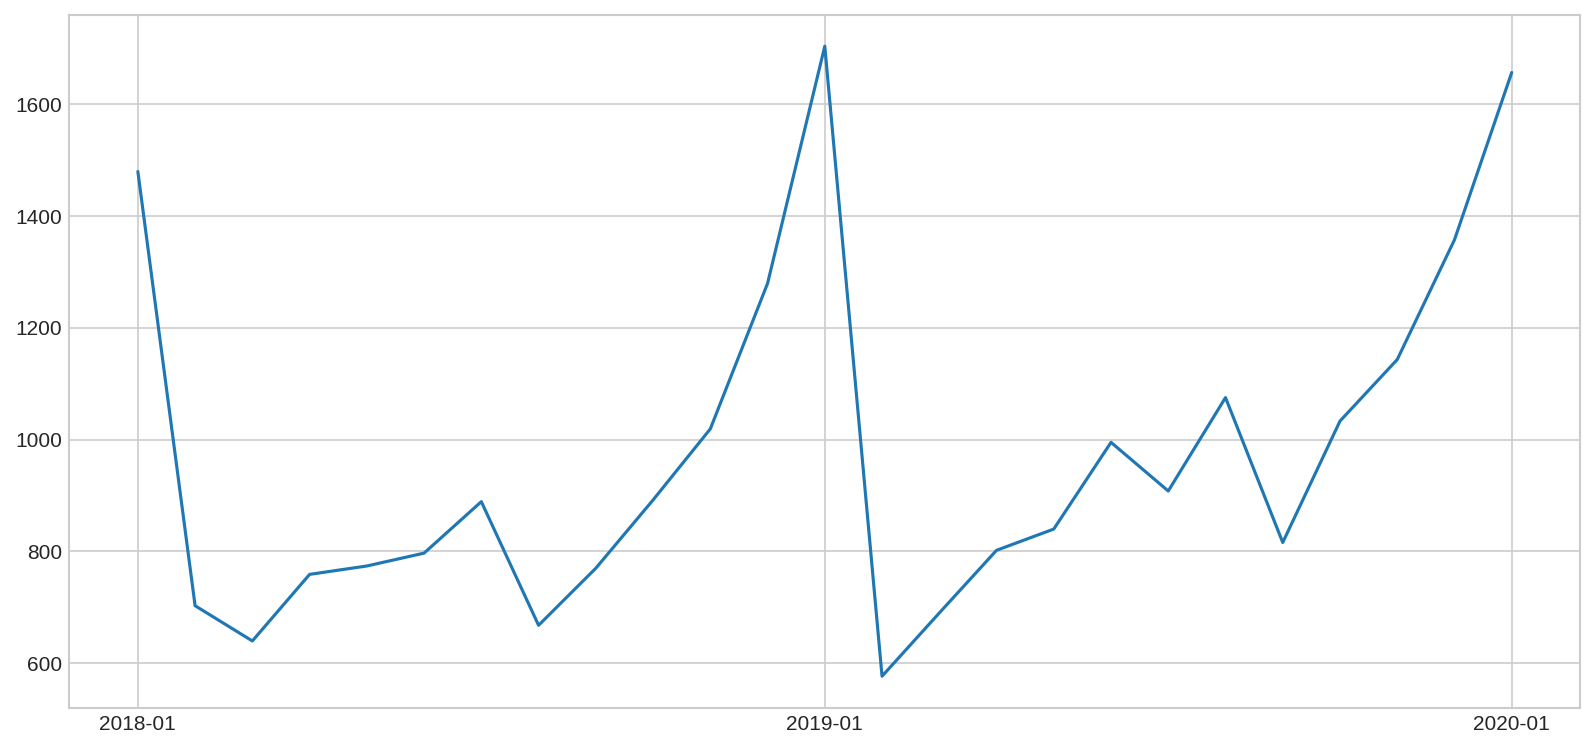

In [14]:
plt.figure(figsize=(13, 6), dpi=150)
plt.plot(music_ts)
plt.xticks(music_ts.index[::120])
plt.show()

plt.figure(figsize=(13, 6), dpi=150)
plt.plot(music_ts_recent)
plt.xticks(music_ts_recent.index[::12])
plt.show()

plt.figure(figsize=(13, 6), dpi=150)
plt.plot(music_ts_actual)
plt.xticks(music_ts_actual.index[::12])
plt.show()

## SSA

Базовое разложение

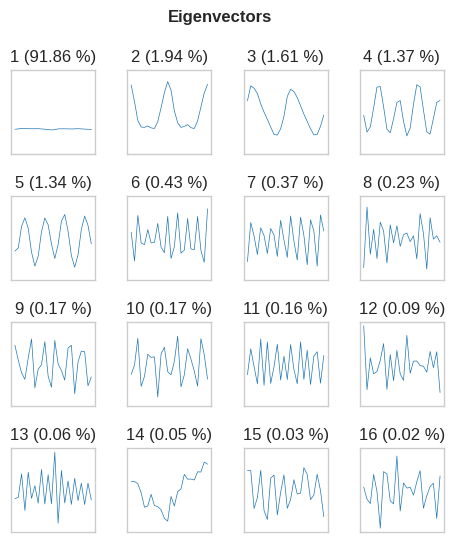

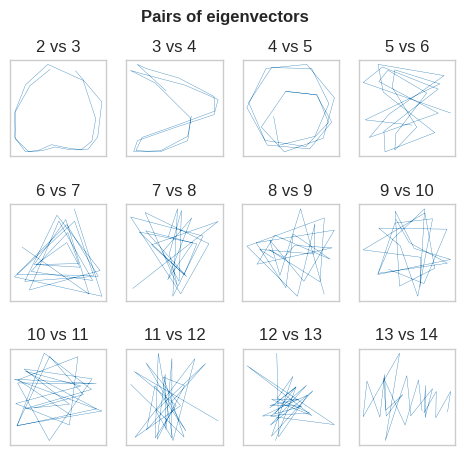

Trend:
   period     rate   |    Mod     Arg  |     Re        Im
      Inf   0.000805 |  1.00081   0.00 |  1.00081   0.00000

Seasonality:
   period     rate   |    Mod     Arg  |     Re        Im
    3.007   0.025242 |  1.02556   2.09 | -0.50815   0.89082
   -3.007   0.025242 |  1.02556  -2.09 | -0.50815  -0.89082
    5.954   0.000502 |  1.00050   1.06 |  0.49326   0.87046
   -5.954   0.000502 |  1.00050  -1.06 |  0.49326  -0.87046
    2.379  -0.002179 |  0.99782   2.64 | -0.87543   0.47883
   -2.379  -0.002179 |  0.99782  -2.64 | -0.87543  -0.47883
    3.928  -0.008625 |  0.99141   1.60 | -0.02858   0.99100
   -3.928  -0.008625 |  0.99141  -1.60 | -0.02858  -0.99100
   11.882  -0.015018 |  0.98509   0.53 |  0.85055   0.49697
  -11.882  -0.015018 |  0.98509  -0.53 |  0.85055  -0.49697
   -2.000  -0.560009 |  0.57120  -3.14 | -0.57120  -0.00000



In [11]:
music_ts_ssa = prs.ssa(music_ts_recent, L=len(music_ts_recent) // 12 // 2 * 12, kind="1d-ssa")
prs.plot(music_ts_ssa, kind="vectors", idx=np.arange(1, 17))
prs.plot(music_ts_ssa, kind="paired", idx=np.arange(2, 15), contrib=False)
print(prs.parestimate(music_ts_ssa, groups={"Trend": 1, "Seasonality": range(2, 13)}, method="esprit"))

### Восстановление по первым 12 компонентам

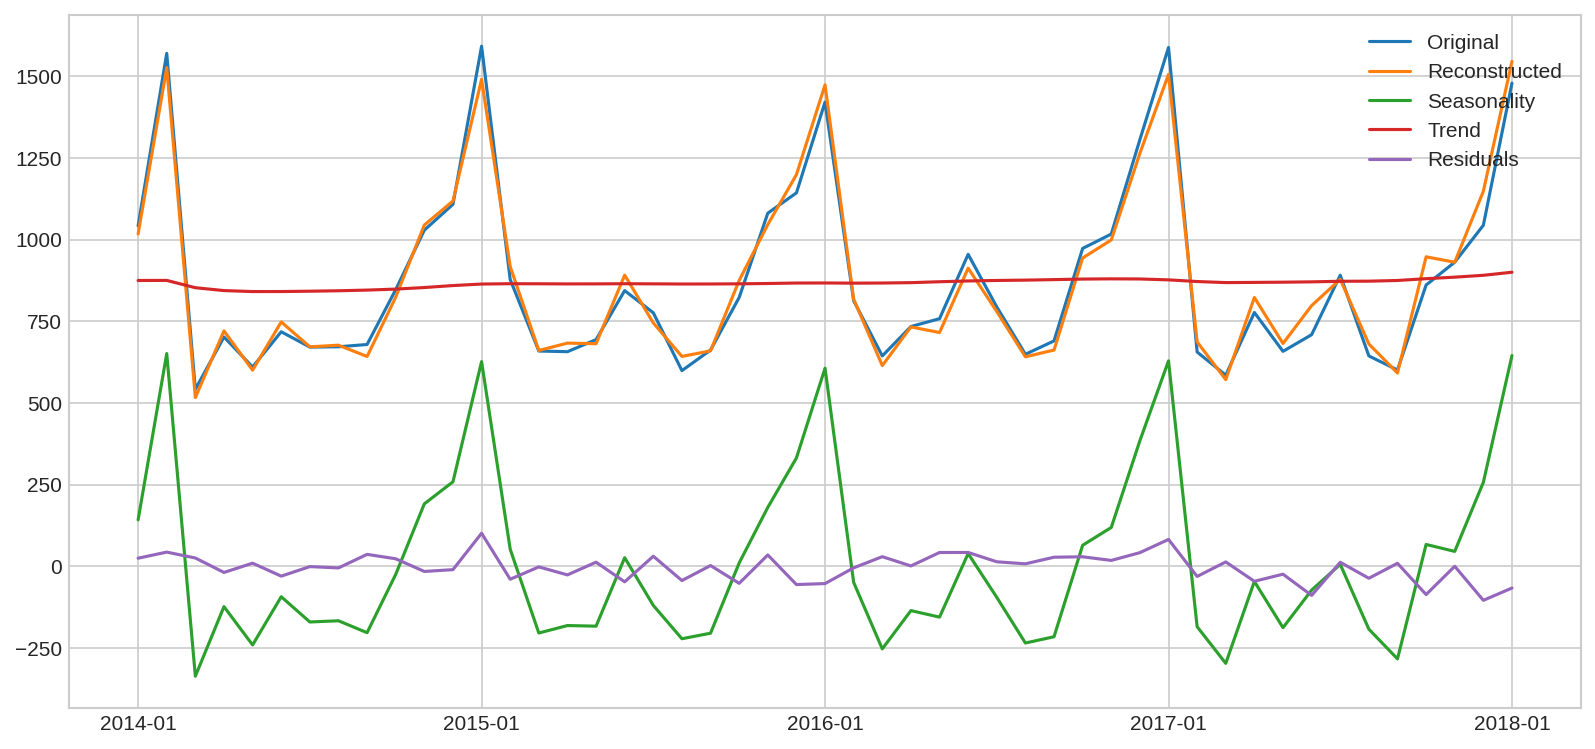

In [12]:
music_ts_rec = prs.reconstruct(music_ts_ssa, groups = {"Signal": range(1, 13), "Trend": 1, "Seasonality": range(2, 13)})

plt.figure(figsize=(13, 6), dpi=150)
plt.plot(music_ts_recent, label="Original")
plt.plot(music_ts_rec.Signal, label = "Reconstructed")
plt.plot(music_ts_rec.Seasonality, label = "Seasonality")
plt.plot(music_ts_rec.Trend, label = "Trend")
plt.plot(music_ts_rec.residuals, label = "Residuals")
plt.xticks(music_ts_recent.index[::12])
plt.legend()
plt.show()

### Предсказание (на 2 года)

Используется векторное предсказание (здесь рекуррентное будет менее точным)

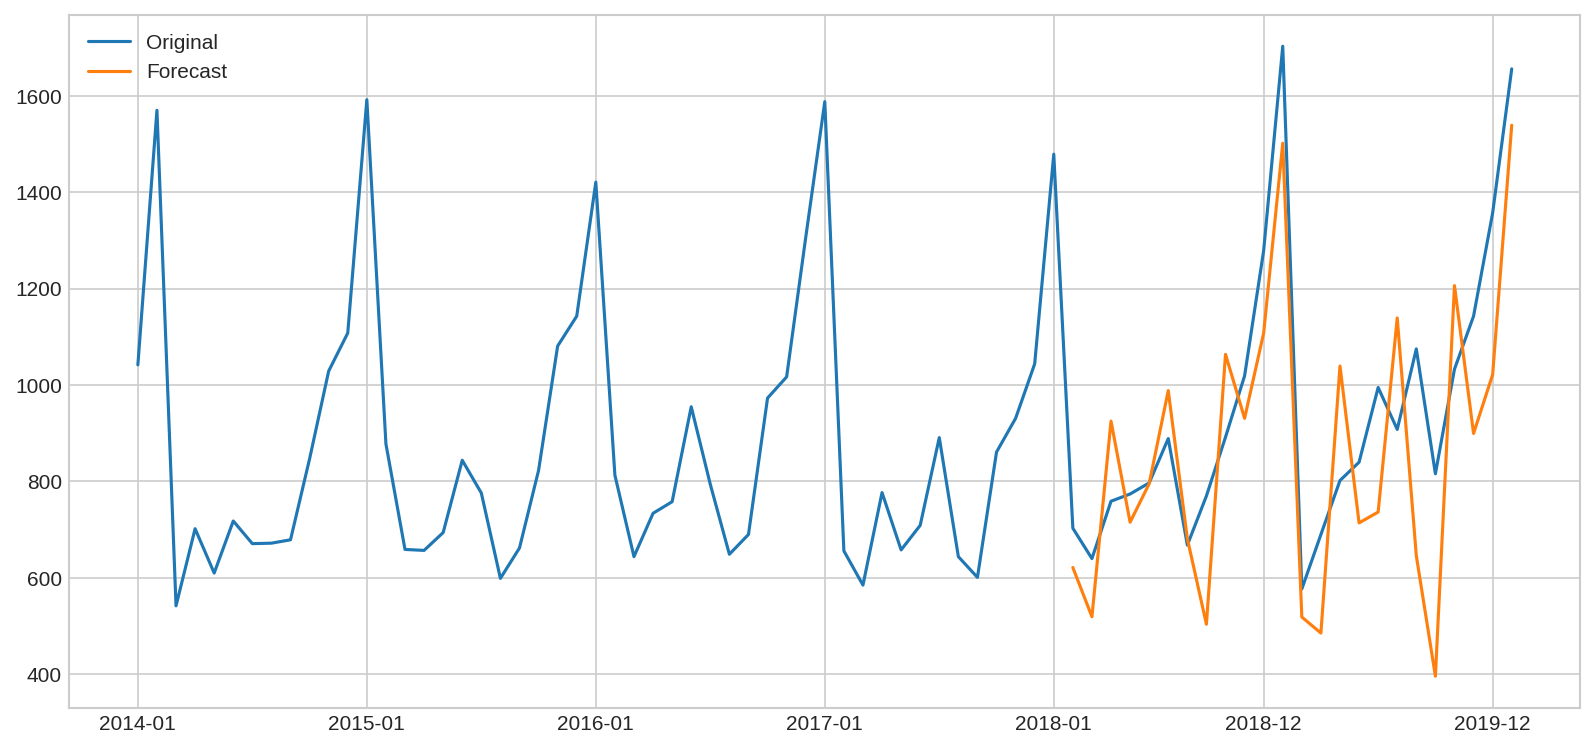

In [16]:
pred_len = 24
music_ts_vfor = prs.vforecast(music_ts_ssa, groups={"Signal": range(1, 13)}, length = pred_len)
music_ts_vfor.index = pd.date_range(start="2018-2", freq='ME', periods=pred_len).strftime('%Y-%m')
# music_ts_vfor = pd.Series(music_ts_vfor, index=music_ts_vfor_index)

music_ts_original = pd.concat([music_ts_recent, music_ts_actual])

plt.figure(figsize=(13, 6), dpi=150)
plt.plot(music_ts_original, label="Original")
plt.plot(music_ts_vfor, label="Forecast")
plt.legend()
plt.xticks(music_ts_original.index[::12])
plt.show()

In [18]:
vfor_rmse = rmse(music_ts_actual_mspe, music_ts_vfor)
print(f"SSA forecast RMSE: {vfor_rmse}")

SSA forecast RMSE: 209.5595232437253


## RNN

In [19]:
# TODO: добавить обучение модели RNN и её предсказание на два 2 года, посчитать RMSE, сравнить